In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder import Autoencoder
import torchvision
from model2 import classification_model
import copy
import partition
from pca import PCADigitReducer
from autoencoder import reduce_dimensions
from training import train,test, train_fashion,test_fashion
from federated_learning import distribute_global_model, federated_averaging
from model4 import MultilayerPerceptron
import cluster

In [2]:
# Predefined stuff

n_epochs = 5
batch_size_train = 100
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,))
])

# Load Kuzushiji-MNIST dataset
train_dataset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
train_loader_pca = copy.copy(train_loader)
test_loader_pca = copy.copy(test_loader)

train_loader_auto = copy.copy(train_loader)
test_loader_auto = copy.copy(test_loader)

In [5]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1] 

# PCA

In [6]:
train_data = []
train_labels = []
for data, labels in train_loader_pca:
    train_data.append(data.view(data.size(0), -1))  
    train_labels.append(labels)
train_data = torch.cat(train_data, dim=0)  
train_labels = torch.cat(train_labels, dim=0)

train_data_np = train_data.numpy()

pca = PCADigitReducer(100)
train_data_reduced = pca.fit_transform(train_data_np)  

train_data_reconstructed_np = pca.inverse_transform(train_data_reduced) 
train_data_reconstructed = torch.tensor(train_data_reconstructed_np, dtype=torch.float32)

train_data_reconstructed = train_data_reconstructed.view(-1, 1, 28, 28)

train_data_reconstructed = (train_data_reconstructed - 0.2860) / 0.3204

batch_size_train = train_loader_pca.batch_size
train_dataset_pca = CustomTensorDataset(train_data_reconstructed, train_labels)
train_loader_reduced_pca = DataLoader(train_dataset_pca, batch_size=batch_size_train, shuffle=True)

# Autoencoder

In [11]:
# Autoencoder
latent_dim = 100  
autoencoder = Autoencoder(latent_dim=latent_dim)
auto_criterion = nn.MSELoss()
auto_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
auto_num_epochs = 5
for epoch in range(auto_num_epochs): 
    for images, _ in train_loader_auto:
        auto_optimizer.zero_grad()
        reconstructed = autoencoder(images)
        loss = auto_criterion(reconstructed, images)  
        loss.backward()
        auto_optimizer.step()
        
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item()}")

Epoch [1/5], Loss: 0.039327871054410934
Epoch [2/5], Loss: 0.02792263589799404
Epoch [3/5], Loss: 0.02447223663330078
Epoch [4/5], Loss: 0.01892860233783722
Epoch [5/5], Loss: 0.019670432433485985


In [13]:
autoencoder.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_features, labels = reduce_dimensions(train_loader_auto, autoencoder.encoder, device)
latent_features = latent_features.detach()

reconstructed_images = autoencoder.decoder(latent_features.to(device))  
reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)

# Partition

In [14]:
# cluster: 6, CLient: 10

In [15]:
alpha = 0.5
num_clients = 10
num_clusters = [2, 4, 6, 8, 10]
results = {"classic": {}, "pca": {}, "autoencoder": {}}
clusteredResults = {"classic": {}, "pca": {}, "autoencoder": {}}

# Classic Dataloaders

In [16]:
trainingset = train_loader.dataset
trial_model_strong = MultilayerPerceptron()
global_model_classic_strong = MultilayerPerceptron()
rounds_classic = 4

In [17]:

partitioned_data_classic = partition.balanced_dirichlet_partition(trainingset, partitions_number=num_clients, alpha=alpha)

# Normal loader classic
classic_client_loaders = [
    DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_classic.values()
]

local_models_classic_strong = [copy.deepcopy(global_model_classic_strong) for _ in range(num_clients)]

optimizer = optim.SGD(trial_model_strong.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []

for epoch in range(1, n_epochs + 1):  
    train_fashion(epoch, trial_model_strong, train_loader, optimizer, log_interval, train_losses, train_counter)

test_losses_classic_strong = []
test_fashion(trial_model_strong,test_loader,test_losses_classic_strong)



for round_idx in range(rounds_classic):
    
    print(f"Round {round_idx + 1}/{rounds_classic}")

    local_weights_classic = []
    for client_idx, client_model in enumerate(local_models_classic_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                      momentum=momentum)

        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_classic.append(client_weights)
        

    global_weights_classic = federated_averaging(local_weights_classic)


    distribute_global_model(global_weights_classic,local_models_classic_strong,single=False)

    distribute_global_model(global_weights_classic,global_model_classic_strong,single=True)
    test_losses = []
    test_fashion(global_model_classic_strong,test_loader,test_losses)

    test_accuracies_classic = []
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(data.shape[0], -1)
            output = global_model_classic_strong(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracies_classic.append(accuracy)

    # Save results for non-clustered classic
    results["classic"]["NoCluster"] = {"losses": [], "accuracy": []}

    results["classic"]["NoCluster"]["losses"].extend(test_losses)
    results["classic"]["NoCluster"]["accuracy"].extend(test_accuracies_classic)


    ######################
for num_cluster in num_clusters:
    import cluster
    cluster = cluster.Cluster(num_clusters=num_cluster)
    
    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_classic, targets, num_classes)
    
    partitioned_data_classic_clustered = clustered_data

    # Clustered loader classic
    classic_client_loaders_clustered = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic_clustered.values()
    ]

    for round_idx in range(rounds_classic):
            print(f"Round {round_idx + 1}/{rounds_classic}")
    
            local_weights_classic = []
            for client_idx, client_model in enumerate(local_models_classic_strong[0:num_cluster]):
                print(f"Training client {client_idx + 1}")
                
                optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                              momentum=momentum)
        
                train_losses = []
                train_counter = []
        
                for epoch in range(1, n_epochs + 1):  
                    train_fashion(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
                
                client_weights = [param.data.numpy() for param in client_model.parameters()]
                local_weights_classic.append(client_weights)
                
        
            global_weights_classic = federated_averaging(local_weights_classic)
        
        
            distribute_global_model(global_weights_classic,local_models_classic_strong,single=False)
        
            distribute_global_model(global_weights_classic,global_model_classic_strong,single=True)
            test_losses = []
            test_fashion(global_model_classic_strong,test_loader,test_losses)
    
            test_accuracies_classic = []
            correct = 0
            with torch.no_grad():
                for data, target in test_loader:
                    data = data.view(data.shape[0], -1)
                    output = global_model_classic_strong(data)
                    pred = output.data.max(1, keepdim=True)[1]
                    correct += pred.eq(target.data.view_as(pred)).sum().item()
            accuracy = 100. * correct / len(test_loader.dataset)
            test_accuracies_classic.append(accuracy)
    
            # Save results for clustered classic
            if num_cluster not in clusteredResults["classic"]:
                clusteredResults["classic"][num_cluster] = {"losses": [], "accuracy": []}
    
            clusteredResults["classic"][num_cluster]["losses"].extend(test_losses)
            clusteredResults["classic"][num_cluster]["accuracy"].extend(test_accuracies_classic)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316336
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.283454
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.315551
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.300179
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.288529
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.270949
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.267949
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.291444
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.262211
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.245188
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.247500
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.239357
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.217642
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.207436
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.188569
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.200631
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.171941
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.169030
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.076976
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.089388
Train Epoch: 1 [12800/60000 (

C:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6630, Accuracy: 7935/10000 (79%)

Round 1/4
Training client 1
Train Epoch: 1 [0/2540 (0%)]	Loss: 2.286468
Train Epoch: 1 [640/2540 (25%)]	Loss: 2.229086
Train Epoch: 1 [1280/2540 (50%)]	Loss: 2.162483
Train Epoch: 1 [1920/2540 (75%)]	Loss: 2.115055
Train Epoch: 2 [0/2540 (0%)]	Loss: 2.031783
Train Epoch: 2 [640/2540 (25%)]	Loss: 1.978113
Train Epoch: 2 [1280/2540 (50%)]	Loss: 1.770007
Train Epoch: 2 [1920/2540 (75%)]	Loss: 1.612729
Train Epoch: 3 [0/2540 (0%)]	Loss: 1.605139
Train Epoch: 3 [640/2540 (25%)]	Loss: 1.687352
Train Epoch: 3 [1280/2540 (50%)]	Loss: 1.481405
Train Epoch: 3 [1920/2540 (75%)]	Loss: 1.364600
Train Epoch: 4 [0/2540 (0%)]	Loss: 1.283612
Train Epoch: 4 [640/2540 (25%)]	Loss: 1.513310
Train Epoch: 4 [1280/2540 (50%)]	Loss: 1.565934
Train Epoch: 4 [1920/2540 (75%)]	Loss: 1.045280
Train Epoch: 5 [0/2540 (0%)]	Loss: 1.128124
Train Epoch: 5 [640/2540 (25%)]	Loss: 1.443170
Train Epoch: 5 [1280/2540 (50%)]	Loss: 1.318441
Train Epoch: 5 [1920/2540 (

In [18]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.9845865989685059], 'accuracy': [68.45]}}, 'pca': {}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [1.1345565049171449, 1.1234910082817078, 1.0988764269828797, 1.0871317828178406], 'accuracy': [67.04, 67.31, 68.65, 69.09]}, 4: {'losses': [0.9308622269630432, 0.891534407043457, 0.8761647099018097, 0.8609776149272919], 'accuracy': [72.01, 72.67, 73.18, 73.78]}, 6: {'losses': [0.7722720616817474, 0.7449284287452698, 0.7328312993049622, 0.7303439470291138], 'accuracy': [75.74, 76.73, 77.2, 77.27]}, 8: {'losses': [0.6871027094364166, 0.669166082572937, 0.6604291471004486, 0.6476429474830627], 'accuracy': [78.5, 79.27, 79.56, 80.07]}, 10: {'losses': [0.6317215486049652, 0.613151860332489, 0.6034009292602539, 0.5951034026622772], 'accuracy': [80.64, 81.35, 81.73, 81.97]}}, 'pca': {}, 'autoencoder': {}}


# PCA Dataloaders

In [19]:
# pca 
trainingset_pca = train_loader_reduced_pca.dataset
trial_model_pca_strong = MultilayerPerceptron()
global_model_pca_strong = MultilayerPerceptron()


In [20]:

partitioned_data_pca = partition.balanced_dirichlet_partition(trainingset_pca, partitions_number=num_clients, alpha=alpha)

pca_client_loaders = [
    DataLoader(Subset(trainingset_pca, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_pca.values()
]

local_models_pca_strong = [copy.deepcopy(global_model_pca_strong) for _ in range(num_clients)]

# Pca strong
optimizer = optim.SGD(trial_model_pca_strong.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []

for epoch in range(1, n_epochs + 1):  
    train_fashion(epoch, trial_model_pca_strong, train_loader_reduced_pca, optimizer, log_interval, train_losses, train_counter)

test_losses_pca_strong = []
test_fashion(trial_model_pca_strong,train_loader_reduced_pca,test_losses_pca_strong)

rounds_pca = 4
for round_idx in range(rounds_pca):
    
    print(f"Round {round_idx + 1}/{rounds_pca}")

    local_weights_pca = []
    for client_idx, client_model in enumerate(local_models_pca_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                      momentum=momentum)

        train_losses = []
        train_counter = []


        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_pca.append(client_weights)
        

    global_weights_pca = federated_averaging(local_weights_pca)

    distribute_global_model(global_weights_pca,local_models_pca_strong,single=False)

    distribute_global_model(global_weights_pca,global_model_pca_strong,single=True)
    test_losses = []
    test_fashion(global_model_pca_strong,test_loader_pca,test_losses)

    test_accuracies_classic = []
    correct = 0
    with torch.no_grad():
        for data, target in test_loader_pca:
            data = data.view(data.shape[0], -1)
            output = global_model_pca_strong(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader_pca.dataset)
    test_accuracies_classic.append(accuracy)

    # Save results for non-clustered classic
    results["pca"]["NoCluster"] = {"losses": [], "accuracy": []}

    results["pca"]["NoCluster"]["losses"].extend(test_losses)
    results["pca"]["NoCluster"]["accuracy"].extend(test_accuracies_classic)

    ##############33
for num_cluster in num_clusters:
    import cluster
    cluster = cluster.Cluster(num_clusters=num_cluster)
    
    targets = trainingset_pca.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_pca, targets, num_classes)
    
    partitioned_data_pca_clustered = clustered_data

    pca_client_loaders_clustered = [
        DataLoader(Subset(trainingset_pca, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_pca_clustered.values()
    ]


    for round_idx in range(rounds_classic):
            print(f"Round {round_idx + 1}/{rounds_classic}")
    
            local_weights_pca = []
            for client_idx, client_model in enumerate(local_models_pca_strong[0:num_cluster]):
                print(f"Training client {client_idx + 1}")
                
                optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                              momentum=momentum)
        
                train_losses = []
                train_counter = []
        
        
                for epoch in range(1, n_epochs + 1):  
                    train_fashion(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
                
                client_weights = [param.data.numpy() for param in client_model.parameters()]
                local_weights_pca.append(client_weights)
                
        
            global_weights_pca = federated_averaging(local_weights_pca)
        
            distribute_global_model(global_weights_pca,local_models_pca_strong,single=False)
        
            distribute_global_model(global_weights_pca,global_model_pca_strong,single=True)
            test_losses = []
            test_fashion(global_model_pca_strong,test_loader_pca,test_losses)
        
            test_accuracies_classic = []
            correct = 0
            with torch.no_grad():
                for data, target in test_loader_pca:
                    data = data.view(data.shape[0], -1)
                    output = global_model_pca_strong(data)
                    pred = output.data.max(1, keepdim=True)[1]
                    correct += pred.eq(target.data.view_as(pred)).sum().item()
            accuracy = 100. * correct / len(test_loader_pca.dataset)
            test_accuracies_classic.append(accuracy)
    
            # Save results for clustered classic
            if num_cluster not in clusteredResults["pca"]:
                clusteredResults["pca"][num_cluster] = {"losses": [], "accuracy": []}
    
            clusteredResults["pca"][num_cluster]["losses"].extend(test_losses)
            clusteredResults["pca"][num_cluster]["accuracy"].extend(test_accuracies_classic)
        

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.284883
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.290972
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.238759
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.185338
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.108814
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.008067
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.904071
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.867947
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.661231
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.605119
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.607865
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.281125
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.233098
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.319546
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.281409
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.119282
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.054006
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.068250
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.828171
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.166737
Train Epoch: 1 [12800/60000 (

In [21]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.9845865989685059], 'accuracy': [68.45]}}, 'pca': {'NoCluster': {'losses': [1.5101947120666503], 'accuracy': [66.03]}}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [1.1345565049171449, 1.1234910082817078, 1.0988764269828797, 1.0871317828178406], 'accuracy': [67.04, 67.31, 68.65, 69.09]}, 4: {'losses': [0.9308622269630432, 0.891534407043457, 0.8761647099018097, 0.8609776149272919], 'accuracy': [72.01, 72.67, 73.18, 73.78]}, 6: {'losses': [0.7722720616817474, 0.7449284287452698, 0.7328312993049622, 0.7303439470291138], 'accuracy': [75.74, 76.73, 77.2, 77.27]}, 8: {'losses': [0.6871027094364166, 0.669166082572937, 0.6604291471004486, 0.6476429474830627], 'accuracy': [78.5, 79.27, 79.56, 80.07]}, 10: {'losses': [0.6317215486049652, 0.613151860332489, 0.6034009292602539, 0.5951034026622772], 'accuracy': [80.64, 81.35, 81.73, 81.97]}}, 'pca': {2: {'losses': [1.4605427358627319, 1.40964434871673

# Autoencoder Dataloader

In [23]:
trainingset_auto = reduced_train_loader_auto.dataset
trial_model_auto_strong = MultilayerPerceptron()
global_model_auto_strong = MultilayerPerceptron()

In [24]:

partitioned_data_auto = partition.balanced_dirichlet_partition(trainingset_auto, partitions_number=num_clients, alpha=alpha)

# Normal loader autoencoder
auto_client_loaders = [
    DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_auto.values()
]

local_model_autoencoder_strong = [copy.deepcopy(global_model_auto_strong) for _ in range(num_clients)]

# Auto strong
optimizer = optim.SGD(trial_model_auto_strong.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []

for epoch in range(1, n_epochs + 1):  
    train_fashion(epoch, trial_model_auto_strong, reduced_train_loader_auto, optimizer, log_interval, train_losses, train_counter)

test_losses_auto_strong = []
test_fashion(trial_model_auto_strong,reduced_train_loader_auto,test_losses_auto_strong)

rounds_auto = 4
for round_idx in range(rounds_auto):
    print(f"Round {round_idx + 1}/{rounds_auto}")
    
    local_weights_auto = []
    for client_idx, client_model in enumerate(local_model_autoencoder_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
        
        train_losses = []
        train_counter = []
    
        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, auto_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_auto.append(client_weights)
    
    global_weights_auto = federated_averaging(local_weights_auto)
    
    distribute_global_model(global_weights_auto, local_model_autoencoder_strong, single=False)
    distribute_global_model(global_weights_auto, global_model_auto_strong, single=True)
    
    test_losses = []
    test_fashion(global_model_auto_strong, test_loader_auto, test_losses)
    
    test_accuracies_classic = []
    correct = 0
    with torch.no_grad():
        for data, target in test_loader_auto:
            data = data.view(data.shape[0], -1)
            output = global_model_auto_strong(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(test_loader_auto.dataset)
    test_accuracies_classic.append(accuracy)
    
    # Save results for non-clustered classic
    results["autoencoder"]["NoCluster"] = {"losses": [], "accuracy": []}
    
    results["autoencoder"]["NoCluster"]["losses"].extend(test_losses)
    results["autoencoder"]["NoCluster"]["accuracy"].extend(test_accuracies_classic)

    ######################
for num_cluster in num_clusters:
    import cluster
    cluster = cluster.Cluster(num_clusters=num_cluster)
    
    targets = trainingset_auto.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_auto, targets, num_classes)
    
    partitioned_data_auto_clustered = clustered_data

    auto_client_loaders_clustered = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto_clustered.values()
    ]

    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
        
        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder_strong[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []
        
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, auto_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
        
        global_weights_auto = federated_averaging(local_weights_auto)
        
        distribute_global_model(global_weights_auto, local_model_autoencoder_strong, single=False)
        distribute_global_model(global_weights_auto, global_model_auto_strong, single=True)
        
        test_losses = []
        test_fashion(global_model_auto_strong, test_loader_auto, test_losses)
        
        test_accuracies_classic = []
        correct = 0
        with torch.no_grad():
            for data, target in test_loader_auto:
                data = data.view(data.shape[0], -1)
                output = global_model_auto_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(test_loader_auto.dataset)
        test_accuracies_classic.append(accuracy)
        
        # Save results for clustered classic
        if num_cluster not in clusteredResults["autoencoder"]:
            clusteredResults["autoencoder"][num_cluster] = {"losses": [], "accuracy": []}
        
        clusteredResults["autoencoder"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["autoencoder"][num_cluster]["accuracy"].extend(test_accuracies_classic)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298621
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.306470
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.285205
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.289761
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.272370
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.286837
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.273456
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.246931
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.243175
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.237414
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.227474
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.214175
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.205111
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.167181
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.157701
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.178448
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.121106
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.064959
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.042418
Train Epoch: 1 [12160/60000 (20%)]	Loss: 2.025156
Train Epoch: 1 [12800/60000 (

In [25]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.9845865989685059], 'accuracy': [68.45]}}, 'pca': {'NoCluster': {'losses': [1.5101947120666503], 'accuracy': [66.03]}}, 'autoencoder': {'NoCluster': {'losses': [0.998846095943451], 'accuracy': [68.21]}}}
Final Results (Clustered): {'classic': {2: {'losses': [1.1345565049171449, 1.1234910082817078, 1.0988764269828797, 1.0871317828178406], 'accuracy': [67.04, 67.31, 68.65, 69.09]}, 4: {'losses': [0.9308622269630432, 0.891534407043457, 0.8761647099018097, 0.8609776149272919], 'accuracy': [72.01, 72.67, 73.18, 73.78]}, 6: {'losses': [0.7722720616817474, 0.7449284287452698, 0.7328312993049622, 0.7303439470291138], 'accuracy': [75.74, 76.73, 77.2, 77.27]}, 8: {'losses': [0.6871027094364166, 0.669166082572937, 0.6604291471004486, 0.6476429474830627], 'accuracy': [78.5, 79.27, 79.56, 80.07]}, 10: {'losses': [0.6317215486049652, 0.613151860332489, 0.6034009292602539, 0.5951034026622772], 'accuracy': [80.64, 81.35, 81.73, 81.9

# Plot


Non-Clustered Results:
classic:
  Average Loss: {'NoCluster': 0.9845865989685059}
  Average Accuracy: {'NoCluster': 68.45}
pca:
  Average Loss: {'NoCluster': 1.5101947120666503}
  Average Accuracy: {'NoCluster': 66.03}
autoencoder:
  Average Loss: {'NoCluster': 0.998846095943451}
  Average Accuracy: {'NoCluster': 68.21}


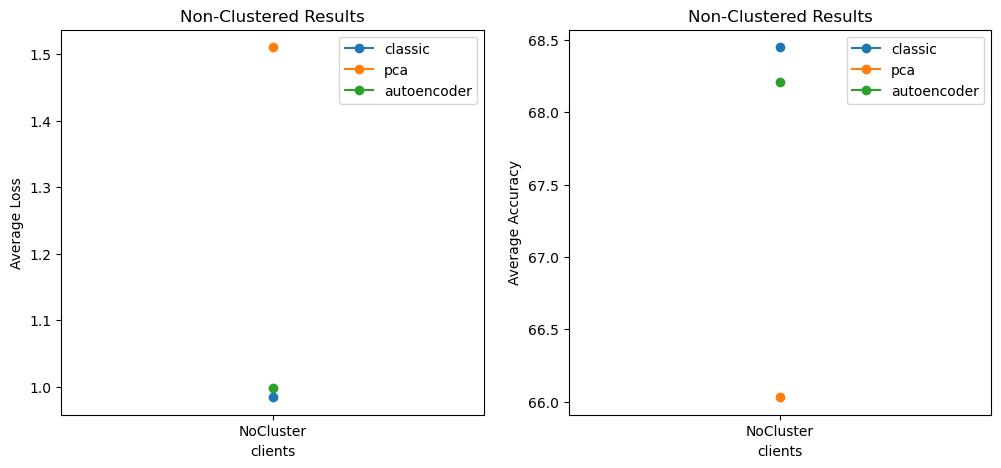


Clustered Results:
classic:
  Average Loss: {2: 1.1110139307498934, 4: 0.8898847397089004, 6: 0.7450939341902733, 8: 0.6660852216482163, 10: 0.6108444352149963}
  Average Accuracy: {2: 68.02250000000001, 4: 72.91, 6: 76.735, 8: 79.35, 10: 81.42250000000001}
pca:
  Average Loss: {2: 1.390624295759201, 4: 1.2545477297782897, 6: 1.182670443201065, 8: 1.123654851102829, 10: 1.0725530294418335}
  Average Accuracy: {2: 68.4, 4: 70.0725, 6: 70.3625, 8: 72.205, 10: 73.14}
autoencoder:
  Average Loss: {2: 0.6465610614299773, 4: 0.542208117377758, 6: 0.5267475606918335, 8: 0.5249126702070236, 10: 0.536298456966877}
  Average Accuracy: {2: 80.2, 4: 83.9725, 6: 84.86, 8: 85.295, 10: 85.07249999999999}


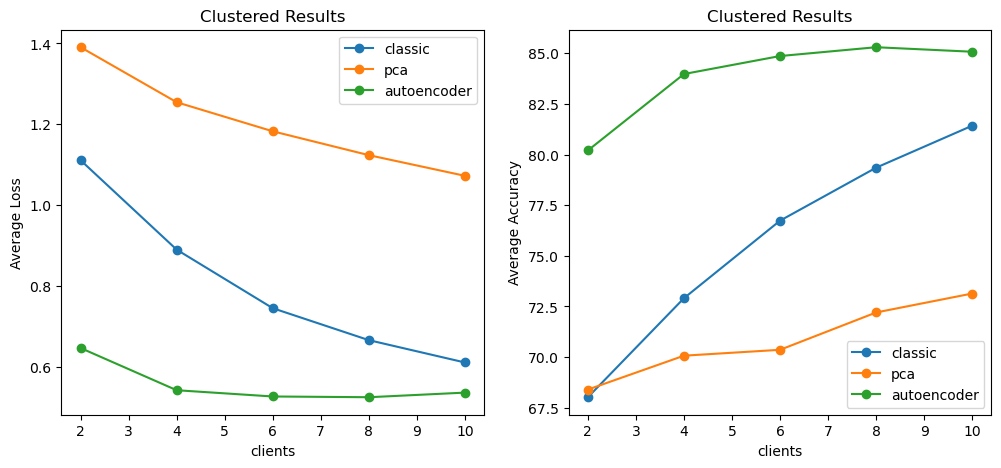

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def compute_avg(metrics):
    avg_loss = {alpha: np.mean(data['losses']) for alpha, data in metrics.items()}
    avg_accuracy = {alpha: np.mean(data['accuracy']) for alpha, data in metrics.items()}
    return avg_loss, avg_accuracy

def print_results(results, title):
    print(f"\n{title}:")
    for method in results.keys():
        avg_loss, avg_accuracy = compute_avg(results[method])
        print(f"{method}:")
        print("  Average Loss:", avg_loss)
        print("  Average Accuracy:", avg_accuracy)

def plot_results(results, title, filename):
    plt.figure(figsize=(12, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    for method in results.keys():
        avg_loss, _ = compute_avg(results[method])
        plt.plot(avg_loss.keys(), avg_loss.values(), marker='o', label=method)
    plt.xlabel('clients')
    plt.ylabel('Average Loss')
    plt.title(f'{title}')
    plt.legend()
    
    # Accuracy Plot
    plt.subplot(1, 2, 2)
    for method in results.keys():
        _, avg_accuracy = compute_avg(results[method])
        plt.plot(avg_accuracy.keys(), avg_accuracy.values(), marker='o', label=method)
    plt.xlabel('clients')
    plt.ylabel('Average Accuracy')
    plt.title(f'{title}')
    plt.legend()
    plt.show()


print_results(results, "Non-Clustered Results")
plot_results(results, "Non-Clustered Results", "non_clustered_results.png")
print_results(clusteredResults, "Clustered Results")
plot_results(clusteredResults, "Clustered Results", "clustered_results.png")